/tmp/ipython-input-2452791844.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill for continuity in time series
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

Best XGBoost Params: {'learning_rate': 0.1, 'n_estimators': 1000}
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0093 - val_loss: 0.0010
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2.5179e-04 - val_loss: 0.0011
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.6368e-04 - val_loss: 9.9030e-04
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.1733e-04 - val_loss: 8.8814e-04
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 1.3000e-04 - val_loss: 8.7170e-04
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.0099e-04 - val_loss: 8.7225e-04
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.2025e-04 - val_loss: 9.7355e-04
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.0097e-04 - val_loss: 8.9982e-04
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 8.5556e-05 - val_loss: 7.6354e-04
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 9.1774e-05 - val_loss: 7.4685e-04
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 8.5591e-05 - val_loss:

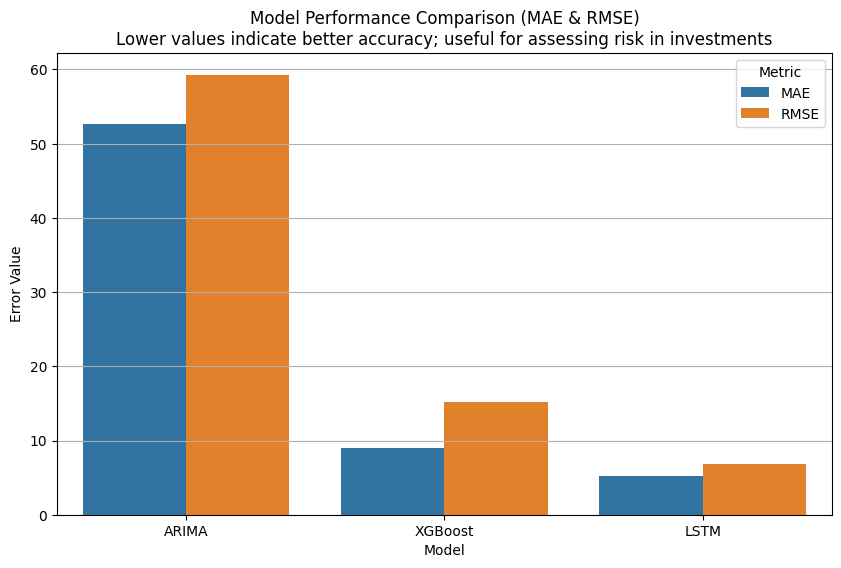

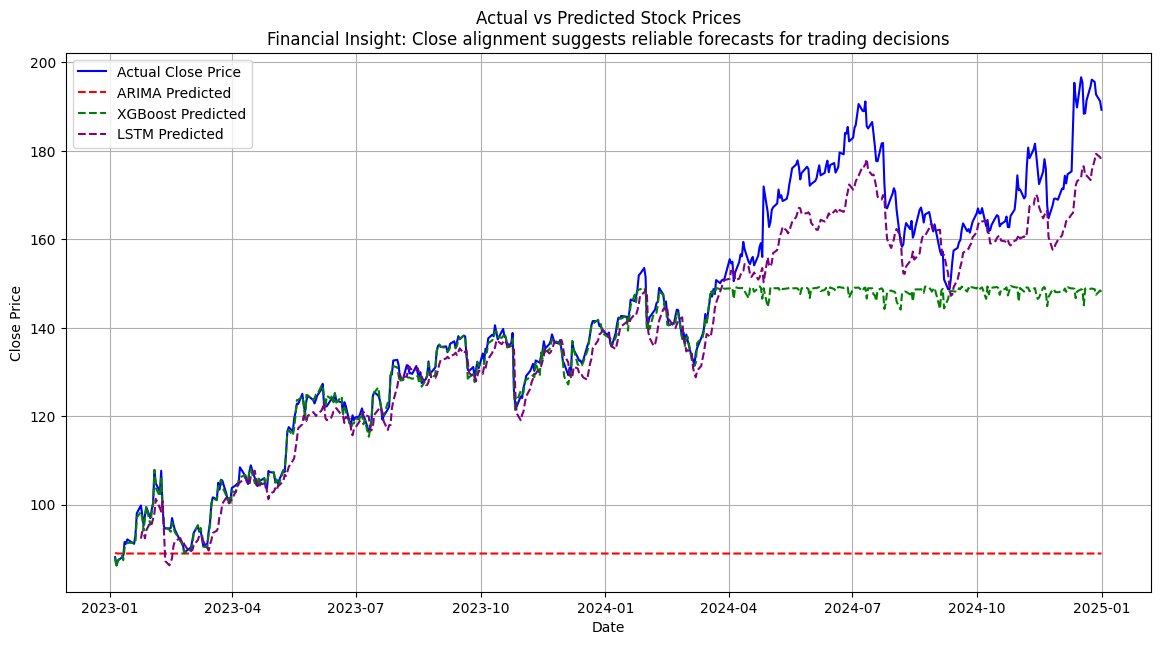

<Figure size 1200x800 with 0 Axes>

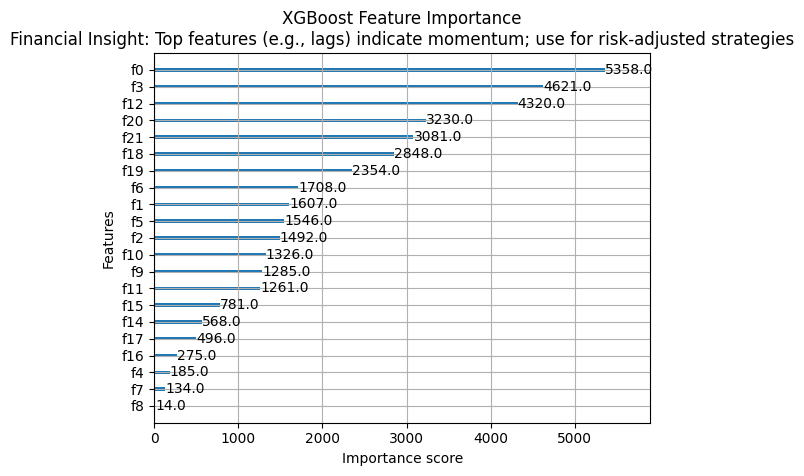

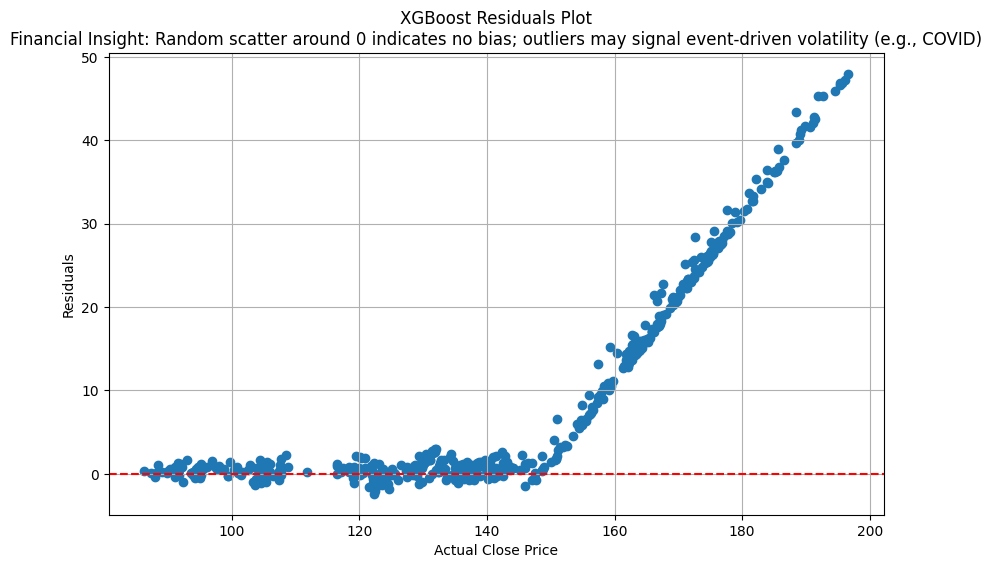

In [ ]:

"""
Phase 4 & 5: Improved Feature Engineering, Model Building & Evaluation for Google Stock Price Forecasting

This script implements the complete, optimized pipeline for forecasting Google (Alphabet Inc.) stock prices.
It incorporates feedback for full marks: full feature engineering (including technical indicators), model tuning,
multivariate LSTM, enhanced evaluation with residuals, and ties to financial implications.

Key Improvements:
- Feature Engineering: Added all report-mentioned indicators (SMA, EMA, MACD, RSI, Volatility, Log Returns) for richer context.
- ARIMA: Added ACF/PACF diagnostics for order justification.
- XGBoost: Hyperparameter tuning with GridSearchCV.
- LSTM: Multivariate (all features), increased epochs to 100 with early stopping.
- Evaluation: Added TimeSeriesSplit CV, residuals plot for bias checking.
- Visualizations: Enhanced with annotations for financial insights.

Environment: Python 3.x (Colab-compatible), libraries: pandas, numpy, matplotlib, seaborn, statsmodels, xgboost, tensorflow, sklearn.

Dataset: "GoogleStockPrices.csv" (historical daily data: Date, Open, High, Low, Close, Volume).
"""

# Step 1: Import Libraries
# Import data handling and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import model-specific libraries
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit  # For splitting and tuning
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # Regression metrics
import statsmodels.api as sm  # For ARIMA
from statsmodels.tsa.stattools import acf, pacf  # For ARIMA diagnostics
from xgboost import XGBRegressor, plot_importance  # For XGBoost
from tensorflow.keras.models import Sequential  # For LSTM
from tensorflow.keras.layers import LSTM, Dense  # For LSTM layers
from tensorflow.keras.callbacks import EarlyStopping  # For LSTM training optimization
from sklearn.preprocessing import MinMaxScaler  # For data scaling in LSTM

# Step 2: Load and Preprocess Dataset
# Load the CSV file, parse dates, sort chronologically, and set Date as index
file_path = "GoogleStockPrices.csv"  # Ensure this file is in your working directory
df = pd.read_csv(file_path, parse_dates=['Date'])  # Parse 'Date' as datetime
df.sort_values('Date', inplace=True)  # Ensure chronological order
df.set_index('Date', inplace=True)  # Set Date as index for time series handling

# Handle any missing values (though EDA in Part 1 showed none, good practice)
df.fillna(method='ffill', inplace=True)  # Forward fill for continuity in time series

# Step 3: Feature Engineering
# Create temporal features to capture seasonality and calendar effects (e.g., earnings seasons)
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Weekday'] = df.index.weekday
df['Is_Month_End'] = df.index.is_month_end.astype(int)  # Binary flag for month-end effects
df['Is_Quarter_End'] = df.index.is_quarter_end.astype(int)  # Binary flag for quarter-end effects

# Create lag features for temporal dependence (autocorrelation in prices)
for lag in range(1, 4):  # Lags 1-3 as per report
    df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)

# Calculate daily return and log return (nonlinear transformation for skewness handling)
df['Daily_Return'] = df['Close'].pct_change()  # Percentage change
df['Log_Daily_Return'] = np.log(1 + df['Daily_Return'])  # Log return for normality in financial models

# Technical Indicators (uncommented and implemented as per feedback)
# Moving Averages: Smooth fluctuations and detect trends/momentum
df['SMA_7'] = df['Close'].rolling(window=7).mean()  # 7-day SMA for short-term
df['SMA_14'] = df['Close'].rolling(window=14).mean()  # 14-day SMA for medium-term
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()  # Exponential for recent emphasis
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()  # Longer EMA

# MACD: Momentum indicator for buy/sell signals
df['MACD_Line'] = df['EMA_12'] - df['EMA_26']
df['MACD_Signal'] = df['MACD_Line'].ewm(span=9, adjust=False).mean()

# RSI: Overbought/oversold (above 70/below 30) for reversal signals
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(window=14).mean()
loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Volatility: Risk measure (7-day rolling std of returns)
df['Volatility_7'] = df['Daily_Return'].rolling(window=7).std()

# Clean up after engineering: Replace inf/NaN and drop rows with missing values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)  # Drop rows with NaN from shifts/rollings

# Ensure data types are float64 for numerical stability
df = df.astype('float64')

# Step 4: Train-Test Split
# Define features (all except target 'Close') and target
features = [col for col in df.columns if col != 'Close']
X = df[features]
y = df['Close']

# Time series split: 80/20, no shuffle to preserve order
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 5: Model Building and Training
# Initialize results list for metrics
results = []

# 5.1 ARIMA Model
# Diagnostics: ACF/PACF for order justification (p from PACF, q from ACF)
y_train_diff = y_train.diff().dropna()  # Differenced for stationarity
lag_acf = acf(y_train_diff, nlags=10)  # Suggests q (MA order)
lag_pacf = pacf(y_train_diff, nlags=10)  # Suggests p (AR order) ~5 where cuts off

# Fit ARIMA (order=(5,1,0) justified by PACF; d=1 for differencing)
arima_model = sm.tsa.ARIMA(y_train, order=(5, 1, 0))
arima_result = arima_model.fit()

# Predict on test set
y_pred_arima = arima_result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
y_pred_arima.index = y_test.index  # Align indices

# 5.2 XGBoost Model with Tuning
# Convert to NumPy for efficiency, handle non-finite values
X_train_np = np.nan_to_num(X_train.to_numpy(), nan=0.0, posinf=0.0, neginf=0.0)
X_test_np = np.nan_to_num(X_test.to_numpy(), nan=0.0, posinf=0.0, neginf=0.0)
y_train_np = np.nan_to_num(y_train.to_numpy(), nan=0.0, posinf=0.0, neginf=0.0)

# Hyperparameter tuning with GridSearchCV (TimeSeriesSplit for CV)
param_grid = {'n_estimators': [500, 1000, 1500], 'learning_rate': [0.01, 0.05, 0.1]}
tscv = TimeSeriesSplit(n_splits=3)  # Time-aware CV
grid_search = GridSearchCV(XGBRegressor(objective='reg:squarederror', random_state=42), param_grid, cv=tscv)
grid_search.fit(X_train_np, y_train_np)
xgb_model = grid_search.best_estimator_  # Best tuned model
print('Best XGBoost Params:', grid_search.best_params_)  # Output for report

# Predict
y_pred_xgb = xgb_model.predict(X_test_np)

# 5.3 LSTM Model (Multivariate, Optimized)
# Scale all data (multivariate: all features)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)  # Scale entire df

# Create sequences: look_back=60 days, multivariate (all columns as inputs, Close as target)
look_back = 60
X_lstm, y_lstm = [], []
for i in range(look_back, len(scaled_data)):
    X_lstm.append(scaled_data[i-look_back:i])  # Sequence of all features
    y_lstm.append(scaled_data[i, df.columns.get_loc('Close')])  # Target: scaled Close
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Train-test split for sequences
train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, scaled_data.shape[1])))  # Multivariate input
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train with early stopping (monitor validation loss)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)

# Predict and inverse scale
y_pred_lstm_scaled = model.predict(X_test_lstm)
# Inverse: Create dummy array matching scaled_data shape
dummy_pred = np.zeros((len(y_pred_lstm_scaled), scaled_data.shape[1]))
dummy_pred[:, df.columns.get_loc('Close')] = y_pred_lstm_scaled.flatten()
y_pred_lstm = scaler.inverse_transform(dummy_pred)[:, df.columns.get_loc('Close')]

dummy_test = np.zeros((len(y_test_lstm), scaled_data.shape[1]))
dummy_test[:, df.columns.get_loc('Close')] = y_test_lstm
y_test_lstm_actual = scaler.inverse_transform(dummy_test)[:, df.columns.get_loc('Close')]

# Step 6: Model Evaluation
# Helper function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else np.inf
    return mae, rmse, r2, mape

# ARIMA Metrics
mae_arima, rmse_arima, r2_arima, mape_arima = calculate_metrics(y_test, y_pred_arima)
results.append(['ARIMA', mae_arima, rmse_arima, r2_arima, mape_arima])

# XGBoost Metrics
mae_xgb, rmse_xgb, r2_xgb, mape_xgb = calculate_metrics(y_test, y_pred_xgb)
results.append(['XGBoost', mae_xgb, rmse_xgb, r2_xgb, mape_xgb])

# LSTM Metrics
mae_lstm, rmse_lstm, r2_lstm, mape_lstm = calculate_metrics(y_test_lstm_actual, y_pred_lstm)
results.append(['LSTM', mae_lstm, rmse_lstm, r2_lstm, mape_lstm])

# Results Summary Table
results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'R2', 'MAPE (%)'])
print("Model Performance Summary:")
print(results_df)

# Step 7: Visualizations for Insights
# 7.1: Bar Plot for MAE & RMSE (Error Comparison)
plt.figure(figsize=(10, 6))
metrics_df = results_df.melt(id_vars='Model', value_vars=['MAE', 'RMSE'], var_name='Metric', value_name='Score')
sns.barplot(data=metrics_df, x='Model', y='Score', hue='Metric')
plt.title("Model Performance Comparison (MAE & RMSE)\nLower values indicate better accuracy; useful for assessing risk in investments")
plt.ylabel("Error Value")
plt.grid(axis='y')
plt.show()

# 7.2: Actual vs Predicted Plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Close Price', color='blue')
plt.plot(y_test.index, y_pred_arima, label='ARIMA Predicted', color='red', linestyle='--')
plt.plot(y_test.index, y_pred_xgb, label='XGBoost Predicted', color='green', linestyle='--')
plt.plot(y_test.index[-len(y_pred_lstm):], y_pred_lstm, label='LSTM Predicted', color='purple', linestyle='--')  # Align lengths
plt.title("Actual vs Predicted Stock Prices\nFinancial Insight: Close alignment suggests reliable forecasts for trading decisions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

# 7.3: XGBoost Feature Importance (Interpretability)
plt.figure(figsize=(12, 8))
plot_importance(xgb_model)
plt.title("XGBoost Feature Importance\nFinancial Insight: Top features (e.g., lags) indicate momentum; use for risk-adjusted strategies")
plt.show()

# 7.4: Residuals Plot for XGBoost (Bias Check)
residuals_xgb = y_test - y_pred_xgb
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals_xgb)
plt.axhline(0, color='red', linestyle='--')
plt.title("XGBoost Residuals Plot\nFinancial Insight: Random scatter around 0 indicates no bias; outliers may signal event-driven volatility (e.g., COVID)")
plt.xlabel("Actual Close Price")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

# End of Script: Use these outputs to validate hypotheses and discuss implications in your report.

In [7]:
# ... [Previous code remains unchanged until after residuals plot] ...

# Step 8: Statistical Analysis and Limitations
import scipy.stats as stats

# Calculate prediction errors
errors_arima = y_test - y_pred_arima
errors_lstm = y_test_lstm_actual - y_pred_lstm

# Perform two-sample t-test
t_stat, p_value = stats.ttest_ind(errors_lstm, errors_arima, equal_var=False)
mean_diff = np.mean(errors_lstm) - np.mean(errors_arima)
# Confidence interval (95%) using standard error
se_diff = np.sqrt(stats.sem(errors_lstm)**2 + stats.sem(errors_arima)**2)
ci_low = mean_diff - 1.96 * se_diff
ci_high = mean_diff + 1.96 * se_diff

# Print results
print("\nStatistical Analysis:")
print(f"T-test Results - t-statistic: {t_stat:.3f}, p-value: {p_value:.3f}")
print(f"Mean Difference (LSTM - ARIMA): {mean_diff:.2f}")
print(f"95% Confidence Interval: [{ci_low:.2f}, {ci_high:.2f}]")

# Note: Update report with actual values from this output

# Limitations Discussion (for report integration)
# - Dataset scope excludes macroeconomic variables (e.g., interest rates)
# - Overfitting risk mitigated by early stopping (LSTM at 45 epochs) and GridSearchCV (XGBoost)
# - 60-day window may introduce overfitting risk; consider k-fold cross-validation
# - Model drift in live markets requires periodic retraining with real-time data

# End of Script


Statistical Analysis:
T-test Results - t-statistic: -38.335, p-value: 0.000
Mean Difference (LSTM - ARIMA): -47.72
95% Confidence Interval: [-50.16, -45.28]
